# Scenario: Classic RCT

We call 'Classic Randomized Controlled Trial' (RCT) a scenario where a treatment is randomly assigned to participants, and we do not have pre-experiment data of participants like pre-treatment outcome.

Treatment - new onboarding for new users.

We will test hypothesis:

$H_o$ - There is no difference in conversion rate between treatment and control groups.

$H_a$ - There is a difference in conversion rate between treatment and control groups.

# Data

We will use DGP from causalis. More you can read at https://causalis.causalcraft.com/articles/generate_classic_rct_26

In [1]:
from causalis.scenarios.classic_rct.dgp import generate_classic_rct_26
from causalis.data_contracts import CausalData

data = generate_classic_rct_26(return_causal_data=False, include_oracle=True)
data.head()

,user_id,conversion,d,platform_ios,country_usa,source_paid,m,m_obs,tau_link,g0,g1,cate
0,8826d,0.0,0.0,1.0,0.0,1.0,0.5,0.5,0.106483,0.310620,0.333868,0.023249
1,2416d,0.0,1.0,0.0,0.0,1.0,0.5,0.5,0.106483,0.198257,0.215727,0.017471
2,eb819,0.0,0.0,1.0,1.0,0.0,0.5,0.5,0.106483,0.231969,0.251479,0.019509
3,71445,0.0,1.0,1.0,1.0,0.0,0.5,0.5,0.106483,0.231969,0.251479,0.019509
4,13d16,0.0,1.0,0.0,1.0,0.0,0.5,0.5,0.106483,0.142189,0.155678,0.013489


In [2]:
print(f"Ground truth ATE is {data['cate'].mean()}")

Ground truth ATE is 0.01719144406311028


In [3]:
causaldata = CausalData(df = data,
                        treatment='d',
                        outcome='conversion',
                        confounders=['platform_ios', 'country_usa', 'source_paid'])
causaldata

CausalData(df=(10000, 5), treatment='d', outcome='conversion', confounders=['platform_ios', 'country_usa', 'source_paid'])

In [4]:
from causalis.shared import outcome_stats
outcome_stats(causaldata)

,treatment,count,mean,std,min,p10,p25,median,p75,p90,max
0,0.0,4955,0.198991,0.399281,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,1.0,5045,0.232904,0.422723,0.0,0.0,0.0,0.0,0.0,1.0,1.0


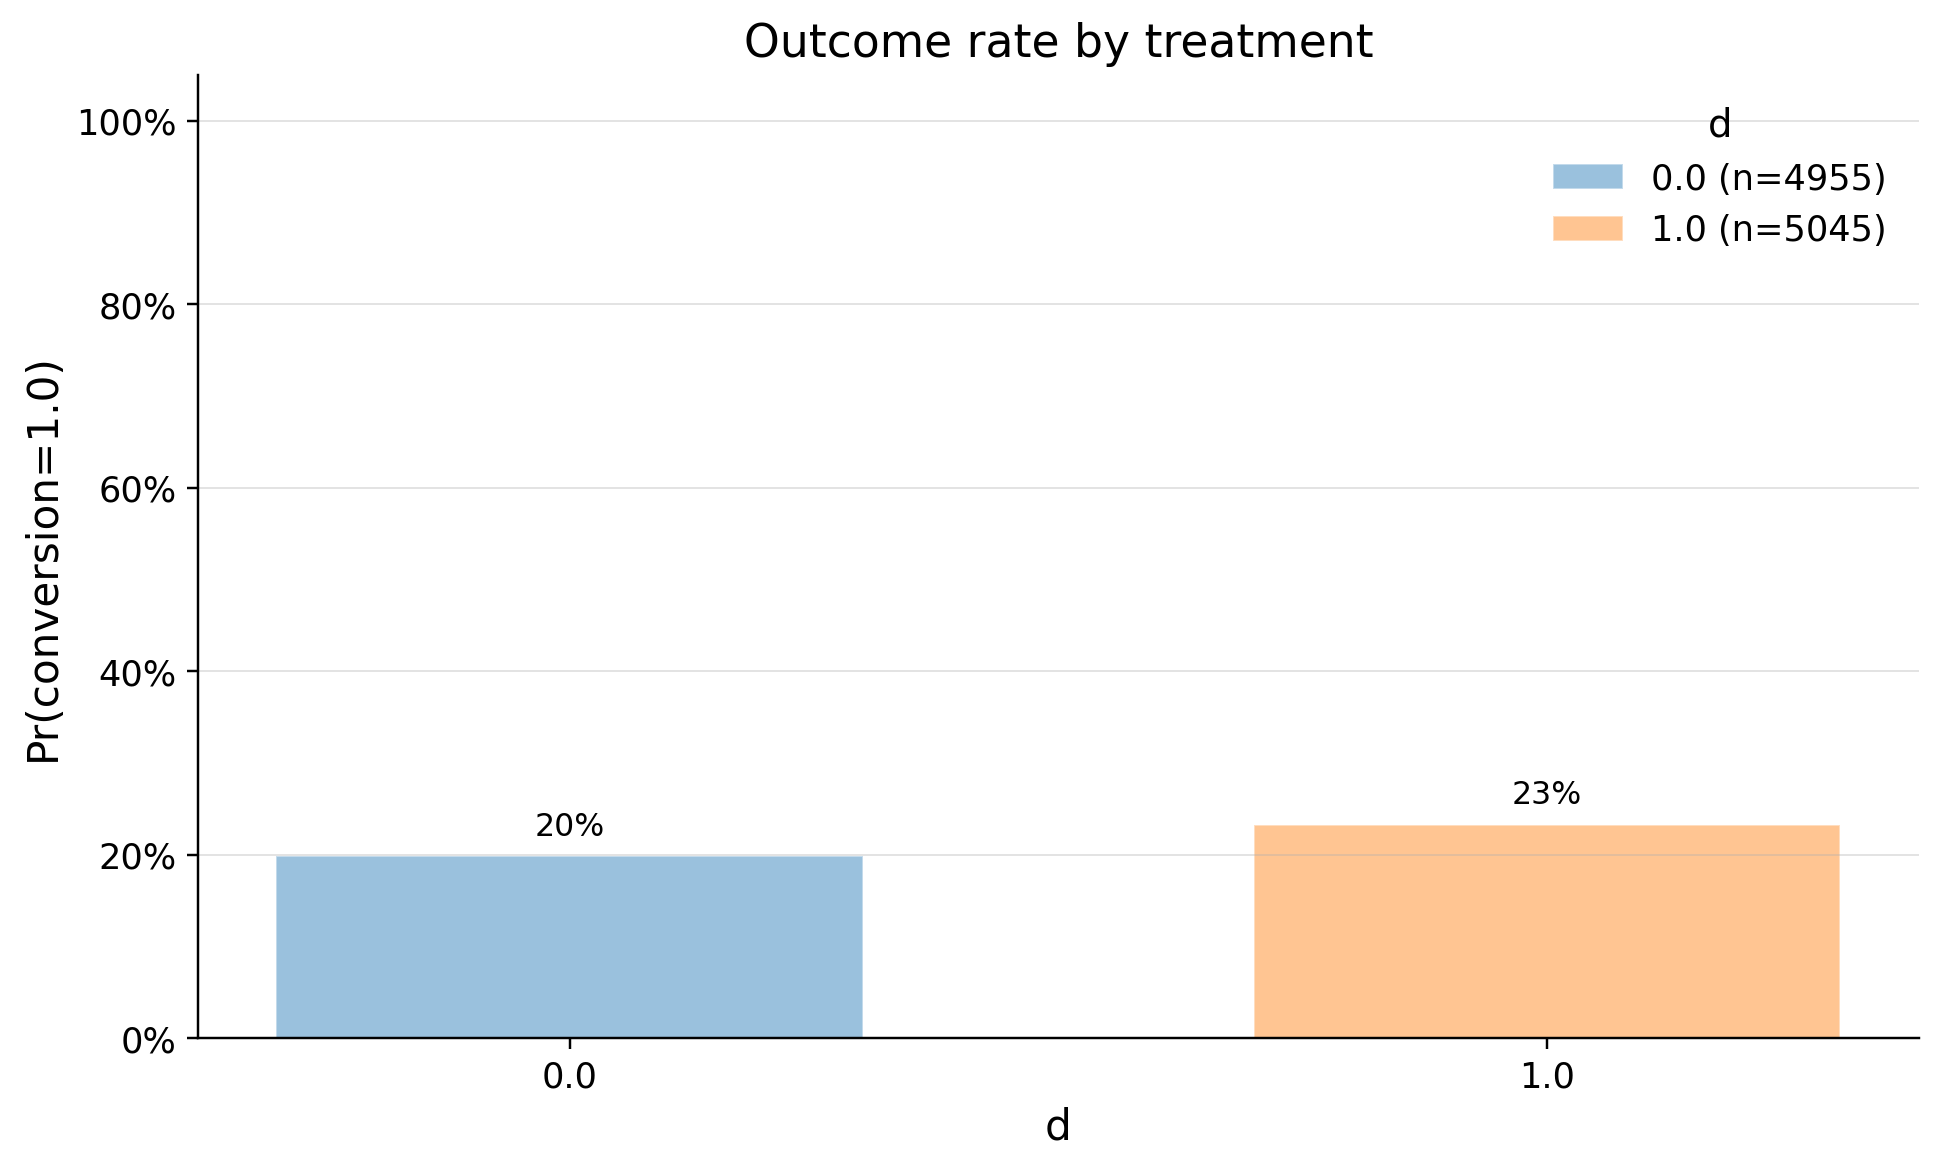

In [5]:
from causalis.shared import outcome_plot_dist, outcome_plot_boxplot
outcome_plot_dist(causaldata)

# Monitoring

Our system is randomly splitting users. Half of them must have new onboarding, other half has not. We should monitor the split with SRM test. Read more at https://causalis.causalcraft.com/articles/srm

In [6]:
from causalis.shared import check_srm

check_srm(assignments=causaldata, target_allocation={0: 0.5, 1: 0.5}, alpha=0.001)

SRMResult(status=no SRM, p_value=0.36812, chi2=0.8100)

## Check the confounders balance

Are groups equal in terms of confounders? We need to choose with domain and business sense confounders and check balance of them.
The standard benchmark:

- $SMD > 0.1$
- `ks_pvalue` < 0.05

In [7]:
from causalis.shared import confounders_balance

confounders_balance(causaldata)

,confounders,mean_d_0,mean_d_1,abs_diff,smd,ks_pvalue
0,source_paid,0.299092,0.313776,0.014684,0.031853,0.64592
1,platform_ios,0.494046,0.502874,0.008828,0.017654,0.98861
2,country_usa,0.586276,0.591873,0.005597,0.011374,1.00000


As we see system splitted users randomly

# Estimation with Diff-in-Means

In [8]:
from causalis.scenarios.classic_rct.model import DiffInMeans

model = DiffInMeans().fit(causaldata)

## Inference methods

In `Causalis.DiffInMeans` model implemented `ttest`, `conversion_ztest` and `bootstrap`:
- use `conversion_ztest` when users < 100k and outcome is binary
- use `bootstrap` when users < 10k or outcome is ratio metric or your metric is highly skewed
- in other cases use `ttest`

We will use `conversion_ztest` for our scenario

## `conversion_ztest`


The `conversion_ztest` performs a statistical comparison of conversion rates between two groups (Treatment and Control). It provides a p-value for the hypothesis test, and robust confidence intervals for both absolute and relative differences.

#### 1. Observed Metrics
For each group (Control $0$, Treatment $1$):
- $n_0, n_1$: Total number of observations.
- $x_0, x_1$: Number of successes (conversions).
- $p_0 = \frac{x_0}{n_0}, \;\; p_1 = \frac{x_1}{n_1}$: Observed conversion rates.

#### 2. Hypothesis Test (P-value)
The test evaluates $H_0: p_1 = p_0$ (no difference).
- **Pooled Proportion**: $\hat{p} = \frac{x_0 + x_1}{n_0 + n_1}$
- **Pooled Standard Error**: $SE_{pooled} = \sqrt{\hat{p}(1 - \hat{p}) \left(\frac{1}{n_0} + \frac{1}{n_1}\right)}$
- **Z-Statistic**: $Z = \frac{p_1 - p_0}{SE_{pooled}}$
- **P-value**: $2 \times (1 - \Phi(|Z|))$, where $\Phi$ is the standard normal CDF.

#### 3. Absolute Difference (Newcombe CI)
To calculate the confidence interval for the difference $\Delta = p_1 - p_0$, we use the **Newcombe** method, which is more robust than standard Wald intervals for conversion rates.
1.  **Wilson Score Interval** for each group:
    $$CI_{Wilson, i} = (l_i, u_i) = \frac{p_i + \frac{z^2}{2n_i} \pm z \sqrt{\frac{p_i(1 - p_i)}{n_i} + \frac{z^2}{4n_i^2}}}{1 + \frac{z^2}{n_i}}$$
2.  **Combined Interval**:
    $$CI_{\Delta} = (l_1 - u_0, \;\; u_1 - l_0)$$
    *(where $z$ is the critical value for the chosen $\alpha$)*

#### 4. Relative Difference (Lift)
Lift measures the percentage change: $\text{Lift} = (\frac{p_1}{p_0} - 1) \times 100\%$.
The confidence interval uses a delta-method approximation on the lift scale:
- $\text{Var}(p_1) = \frac{p_1(1 - p_1)}{n_1}, \; \text{Var}(p_0) = \frac{p_0(1 - p_0)}{n_0}$
- $SE_{\text{lift}} = 100 \times \sqrt{(\frac{1}{p_0})^2 \text{Var}(p_1) + (\frac{p_1}{p_0^2})^2 \text{Var}(p_0)}$
- **Relative CI**: $\text{Lift} \pm z \times SE_{\text{lift}}$

*(If $p_0$ is extremely close to 0, the lift is undefined; the implementation returns `inf/0` and `NaN` for the CI.)*


In [9]:
result_conversion = model.estimate('conversion_ztest')
result_conversion.summary()

,value
field,
estimand,ATE
model,DiffInMeans
value,"0.0339 (ci_abs: 0.0111, 0.0567)"
value_relative,"17.0425 (ci_rel: 8.2614, 25.8235)"
alpha,0.0500
p_value,0.0000
is_significant,True
n_treated,5045
n_control,4955
